In [1]:
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from segnet import segnet
from train import load_dev_set

### Note: Results below are from erronious sample inclusion

Code is fixed, but visualization is not. Last update: 30 September 2020, 3:45pm

In [2]:
prefix='weights/chr20.full.161'
glob.glob(prefix+'*')

['weights/chr20.full.161.var_index.txt',
 'weights/chr20.full.161.v2.dev.sqrt_ivw.h5',
 'weights/chr20.full.161.h5',
 'weights/chr20.full.161.log.csv',
 'weights/chr20.full.161.v2.ivw.h5',
 'weights/chr20.full.161.info.png',
 'weights/chr20.full.161.v2.ivw.log.csv',
 'weights/chr20.full.161.v2.ivw.var_index.txt']

In [3]:
v = np.loadtxt(prefix+'.var_index.txt', dtype=int)
print(v.shape)

(452352,)


In [4]:
model=segnet(input_shape=(v.shape[0], 2), n_classes=5, n_blocks=4, n_filters=12, width=24)
model.compile(tf.keras.optimizers.Adam(lr=3e-4, beta_1=0.9), 
              loss='categorical_crossentropy', metrics=['accuracy'])
model.load_weights(prefix+'.h5')

In [5]:
X, Y, S = load_dev_set()

[(120, 516801, 2), (120, 516801, 5)]


In [6]:
X=X[:,v,:]
Y=Y[:,v,:]
print(X.shape, Y.shape)

(120, 452352, 2) (120, 452352, 5)


In [7]:
loss, acc = model.evaluate(X, Y, batch_size=2, verbose=1)

120/120 [==============================] - 706s 6s/sample - loss: 0.4645 - accuracy: 0.8565


In [8]:
Yhat=model.predict(X)
print(loss, acc)

0.4644923582673073 0.8565428


In [9]:
cf=tf.math.confusion_matrix(Y.dot(np.arange(5)).flatten(), 
                            Yhat.argmax(axis=-1).flatten()).numpy()
np.sum(np.diag(cf))/np.sum(cf)

0.8565432450834748

In [10]:
anc=np.array(['AFR','EAS','EUR','NAT','SAS'])
pd.DataFrame(cf, index=anc, columns=anc)

,AFR,EAS,EUR,NAT,SAS
AFR,16072773,107495,175816,832,284088
EAS,47443,20061055,71680,200631,595500
EUR,253457,280419,5057446,237562,1872729
NAT,6582,993670,87501,3025110,108918
SAS,143345,1230731,904682,184073,2278702


In [11]:
ix=np.array([0,1,2,3,4])
pd.DataFrame(cf[np.ix_(ix,ix)], index=anc[ix], columns=anc[ix])

,AFR,EAS,EUR,NAT,SAS
AFR,16072773,107495,175816,832,284088
EAS,47443,20061055,71680,200631,595500
EUR,253457,280419,5057446,237562,1872729
NAT,6582,993670,87501,3025110,108918
SAS,143345,1230731,904682,184073,2278702


In [12]:
# specificity (column-normalized, diagonal is fraction of A_hat which is truly A)
pd.DataFrame(cf[np.ix_(ix,ix)], index=anc[ix], columns=anc[ix]).divide(
    cf[np.ix_(ix,ix)].sum(axis=0), axis=1)

,AFR,EAS,EUR,NAT,SAS
AFR,0.972716,0.004741,0.027920,0.000228,0.055271
EAS,0.002871,0.884785,0.011383,0.054994,0.115857
EUR,0.015339,0.012368,0.803136,0.065117,0.364349
NAT,0.000398,0.043825,0.013895,0.829204,0.021191
SAS,0.008675,0.054281,0.143666,0.050456,0.443333


In [13]:
# sensitivity (row-normalized, diagonal is fraction of A which we say is A_hat)
pd.DataFrame(cf[np.ix_(ix,ix)], index=anc[ix], columns=anc[ix]).divide(
    cf[np.ix_(ix,ix)].sum(axis=1), axis=0)

,AFR,EAS,EUR,NAT,SAS
AFR,0.965854,0.006460,0.010565,0.000050,0.017072
EAS,0.002262,0.956367,0.003417,0.009565,0.028389
EUR,0.032910,0.036410,0.656674,0.030846,0.243161
NAT,0.001559,0.235367,0.020726,0.716548,0.025799
SAS,0.030232,0.259564,0.190799,0.038821,0.480583


In [14]:
np.sum(np.diag(cf[ix,:][:,ix]))/np.sum(cf[ix,:][:,ix])

0.8565432450834748

In [15]:
from train import load_train_set
from generator import DataGenerator

In [16]:
x,y,s,_,ix,_,_=load_train_set()
t=np.array([i for i in ix if y[i,0,:].dot(np.arange(y.shape[-1])) not in [4,6]])
x=x[np.ix_(t,v,np.arange(x.shape[-1]))]
y=y[np.ix_(t,v,np.array([0,1,2,3,5]))]

[(2764, 516801, 2), (2764, 516801, 7), (2764,), 2090]


In [17]:
if False: # train some more epochs with frequency-weighted loss, then you can rerun the above
    hh=model.fit(DataGenerator(train_ix=np.arange(x.shape[0]), batch_size=8, dim=x.shape[1], 
                               n_alleles=x.shape[-1], n_classes=5, X=x, Y=y, 
                               shuffle=True, sample=True, admix=False, anc_wts=None), 
                 validation_data=DataGenerator(train_ix=np.arange(x.shape[0]), batch_size=8, 
                                               dim=X.shape[1], X=x, Y=y, 
                                               n_alleles=X.shape[-1], n_classes=Y.shape[-1]), 
                 class_weight=np.sqrt(1/cf.sum(axis=1)), epochs=50)

In [18]:
model.load_weights(prefix+'.v2.dev.sqrt_ivw.h5')

In [19]:
loss, acc = model.evaluate(X, Y, batch_size=2, verbose=1)
Yhat=model.predict(X)
print(loss, acc)

120/120 [==============================] - 13s 104ms/sample - loss: 0.2383 - accuracy: 0.9285
0.23825881481170655 0.92848134


In [20]:
cf=tf.math.confusion_matrix(Y.dot(np.arange(5)).flatten(), 
                            Yhat.argmax(axis=-1).flatten()).numpy()
np.sum(np.diag(cf))/np.sum(cf)

0.9284815070269761

In [21]:
anc=np.array(['AFR','EAS','EUR','NAT','SAS'])
ix=np.array([0,1,2,3,4])
pd.DataFrame(cf[np.ix_(ix,ix)], index=anc[ix], columns=anc[ix])

,AFR,EAS,EUR,NAT,SAS
AFR,16133894,111127,68322,1683,325978
EAS,45146,20104787,23963,65368,737045
EUR,225375,65225,6431720,17524,961769
NAT,4513,111656,77458,3976136,52018
SAS,126979,297317,546137,17581,3753519


In [22]:
# specificity (column-normalized, diagonal is fraction of A_hat which is truly A)
pd.DataFrame(cf[np.ix_(ix,ix)], index=anc[ix], columns=anc[ix]).divide(
    cf[np.ix_(ix,ix)].sum(axis=0), axis=1)

,AFR,EAS,EUR,NAT,SAS
AFR,0.975688,0.005371,0.009559,0.000413,0.055911
EAS,0.002730,0.971710,0.003353,0.016028,0.126416
EUR,0.013629,0.003152,0.899843,0.004297,0.164960
NAT,0.000273,0.005397,0.010837,0.974951,0.008922
SAS,0.007679,0.014370,0.076408,0.004311,0.643792


In [23]:
# sensitivity (row-normalized, diagonal is fraction of A which we say is A_hat)
pd.DataFrame(cf[np.ix_(ix,ix)], index=anc[ix], columns=anc[ix]).divide(
    cf[np.ix_(ix,ix)].sum(axis=1), axis=0)

,AFR,EAS,EUR,NAT,SAS
AFR,0.969526,0.006678,0.004106,0.000101,0.019589
EAS,0.002152,0.958452,0.001142,0.003116,0.035137
EUR,0.029263,0.008469,0.835113,0.002275,0.124879
NAT,0.001069,0.026448,0.018347,0.941815,0.012321
SAS,0.026780,0.062705,0.115182,0.003708,0.791626


In [24]:
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline

In [106]:
import scipy.stats as ss
from scipy.ndimage import median_filter
import scipy

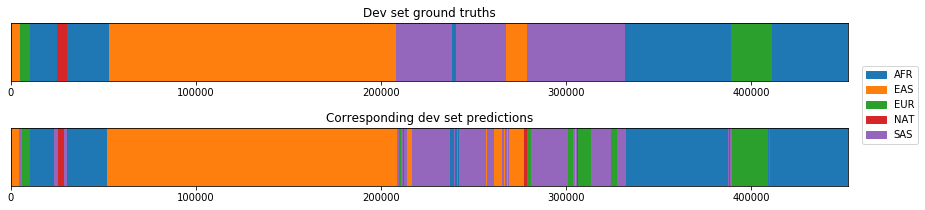

In [120]:
iix=22
plt.figure(figsize=(15, 3))
Yhat_lab = np.argmax(Yhat, axis=-1)
plt.subplot(211)
plt.title('Dev set ground truths')
plt.imshow(Y[iix:iix+1,:,:].argmax(axis=-1).astype(int), aspect='auto', cmap='tab10',
           norm=mpl.colors.Normalize(vmin=0, vmax=10))
plt.yticks([])

plt.subplot(212)
plt.title('Corresponding dev set predictions')
plt.imshow(Yhat[iix:iix+1,:,:].argmax(axis=-1).astype(int), aspect='auto', cmap='tab10', 
           norm=mpl.colors.Normalize(vmin=0, vmax=10))
plt.yticks([])

plt.subplots_adjust(hspace=0.8)
cmap = mpl.cm.get_cmap('tab10')
plt.legend(handles=[mpatches.Patch(color=cmap.colors[i],label=anc[i]) for i in range(len(anc))],
           bbox_to_anchor=(1.09, 2.15))

In [146]:
mfw=2000
#yhat2=median_filter(Yhat_lab[:,:].reshape(1,-1), size=(1,5000))
yhat2=np.zeros(Yhat_lab.shape)
for j in range(Yhat_lab.shape[-1]):
    yhat2[:,j]=ss.mode(Yhat_lab[:,max(0,j-mfw):min(Yhat_lab.shape[-1], j+mfw)], axis=1).mode.flatten()

In [147]:
cf2=tf.math.confusion_matrix(Y.dot(np.arange(5)).flatten(), yhat2.flatten()).numpy()
np.sum(np.diag(cf2))/np.sum(cf2)

0.9438686207496227

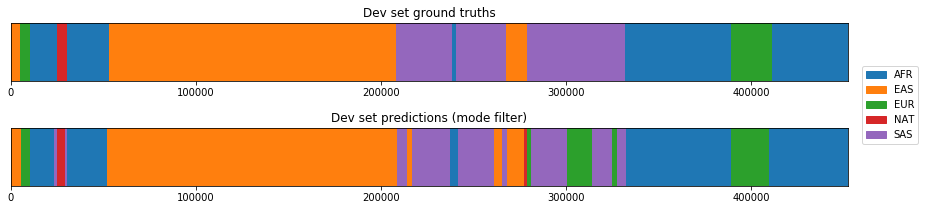

In [148]:
plt.figure(figsize=(15, 3))
plt.subplot(211)
plt.title('Dev set ground truths')
plt.imshow(Y[iix:iix+1,:,:].argmax(axis=-1).astype(int), aspect='auto', cmap=mpl.cm.tab10, 
           norm=mpl.colors.Normalize(vmin=0, vmax=10))
plt.yticks([])

plt.subplot(212)
plt.title('Dev set predictions (mode filter)')
plt.imshow(yhat2[iix:iix+1,:], aspect='auto', cmap=mpl.cm.tab10, norm=mpl.colors.Normalize(vmin=0, vmax=10))
plt.yticks([])

plt.subplots_adjust(hspace=0.8)
cmap = mpl.cm.get_cmap('tab10')
plt.legend(handles=[mpatches.Patch(color=cmap.colors[i],label=anc[i]) for i in range(len(anc))],
           bbox_to_anchor=(1.09, 2.15))

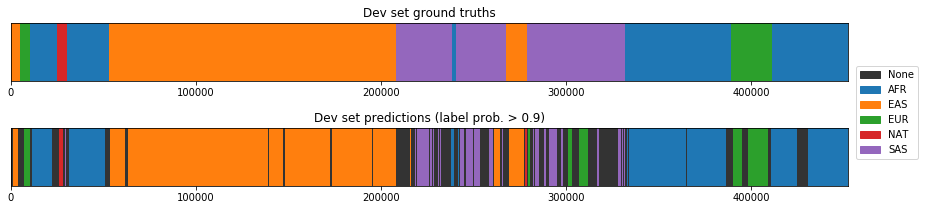

In [149]:
plt.figure(figsize=(15, 3))
plt.subplot(211)
plt.title('Dev set ground truths')
plt.imshow(Y[iix:iix+1,1:,:].argmax(axis=-1).astype(int), aspect='auto', cmap='tab10', 
           norm=mpl.colors.Normalize(vmin=0, vmax=10))
plt.yticks([])

plt.subplot(212)
plt.title('Dev set predictions (label prob. > 0.9)')
plt.imshow((Yhat[iix:iix+1,:,:] > 0.9).dot(np.arange(5)+1).astype(int), aspect='auto', 
           cmap=mpl.colors.ListedColormap([(0.2,0.2,0.2)]+list(mpl.cm.tab10.colors[:-1])),
           norm=mpl.colors.Normalize(vmin=0, vmax=10))
plt.yticks([])

plt.subplots_adjust(hspace=0.8)
cmap = mpl.colors.ListedColormap([(0.2,0.2,0.2)]+list(mpl.cm.tab10.colors[:-1]))
plt.legend(handles=[mpatches.Patch(color=cmap.colors[i],label=anc[i-1] if i else 'None') for i in range(len(anc)+1)],
           bbox_to_anchor=(1.09, 2.15))

In [150]:
pd.DataFrame(cf2[np.ix_(ix,ix)], index=anc[ix], columns=anc[ix])

,AFR,EAS,EUR,NAT,SAS
AFR,16230372,141062,41370,5096,223104
EAS,52116,20416517,20443,25178,462055
EUR,163169,93362,6635001,7079,803002
NAT,10963,79854,31639,4062036,37289
SAS,96551,277836,467913,7856,3891377


In [151]:
# specificity
pd.DataFrame(cf2[np.ix_(ix,ix)], index=anc[ix], columns=anc[ix]).divide(
             cf2[np.ix_(ix,ix)].sum(axis=0), axis=1)

,AFR,EAS,EUR,NAT,SAS
AFR,0.980499,0.006714,0.005749,0.001241,0.041187
EAS,0.003148,0.971816,0.002841,0.006130,0.085300
EUR,0.009857,0.004444,0.921993,0.001724,0.148242
NAT,0.000662,0.003801,0.004397,0.988993,0.006884
SAS,0.005833,0.013225,0.065021,0.001913,0.718387


In [152]:
# sensitivity
pd.DataFrame(cf2[np.ix_(ix,ix)], index=anc[ix], columns=anc[ix]).divide(
             cf2[np.ix_(ix,ix)].sum(axis=1), axis=0)

,AFR,EAS,EUR,NAT,SAS
AFR,0.975324,0.008477,0.002486,0.000306,0.013407
EAS,0.002485,0.973313,0.000975,0.001200,0.022027
EUR,0.021186,0.012122,0.861508,0.000919,0.104264
NAT,0.002597,0.018915,0.007494,0.962162,0.008833
SAS,0.020363,0.058596,0.098684,0.001657,0.820700
